In [2]:
from os.path import exists, join, isfile
from os import listdir, makedirs
from obspy.geodetics import kilometer2degrees
import numpy as np
from obspy.taup import TauPyModel
import matplotlib.pyplot as plt

import threading
import subprocess

import Create_Vmod
from SS_MTI import Gradient, PhaseTracer

# Fixed parameters (initial model)

In [3]:
bin_filepath = "/home/nienke/Documents/Research/SS_MTI/External_packages/reflectivity_Mars/SRC/test/crfl_sac"
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Exact_Gradient"
if not exists(join(save_path_OG, "start_v")):
    makedirs(join(save_path_OG, "start_v"))
f_start = join(save_path_OG, "start_v")

## Fixed parameters:
src_depth = 20.0
epi_in_km = 1774.7380
epi = kilometer2degrees(epi_in_km, radius=3389.5)
baz = 0.0

dt = 0.025

phases = ["P", "S", "P", "S", "S"]
comps = ["Z", "T", "R", "Z", "R"]
t_pres = [1, 1, 1, 1, 1]
t_posts = [30, 30, 30, 30, 30]
ylims = [1e-9, 1e-9, 2e-9, 3e-9, 2e-9]

fmin = 0.2
fmax = 0.6
zerophase = False


## Start parameters:
bm_start_model = "/home/nienke/Documents/Research/Data/MTI/MT_vs_STR/bm_models/TAYAK.bm"
m_rr = 0.2
m_tt = 0.3
m_pp = -0.4
m_rt = -0.2
m_rp = 0.3
m_tp = 0.8
focal_mech = [m_rr, m_tt, m_pp, m_rt, m_rp, m_tp]
Moho_d = 77.0

Create_Vmod.create_dat_file(
    src_depth, epi_in_km, baz, focal_mech, dt, f_start, bm_start_model,
)

m0 = np.hstack((focal_mech, Moho_d))
sigmas = np.ones(len(phases)) * 1e-10

/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))
/home/nienke/Documents/Research/SS_MTI/Scripts_MT_Structure/Create_Vmod.py:298: RuntimeWarning: invalid value encountered in double_scalars
  qp = 1 / (L * (1 / qmu) + (1 - L) * (1 / qka))


# Observed data

In [51]:
path_observed = (
    "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/obs_2/"
)
npz_file = "/home/nienke/Documents/Research/Data/npz_files/TAYAK.npz"
st_obs = Gradient.read_refl_mseeds(path=path_observed)
Taup = TauPyModel(npz_file)
obs_tts = [PhaseTracer.get_traveltime(Taup, phase, src_depth, epi) for phase in phases]
st_obs_w, st_obs_full, s_obs = Gradient.window(
    st_obs, phases, comps, obs_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

# Exact gradient calculation

In [5]:
def Exact_gradient(
    thread_folder: str,
    thread_nr: int,
    dat_folder: str,
    unit_v: np.array,
    bin_filepath: str,
):
    print(thread_nr)
    print(unit_v)
    """ Thread worker function """

    """ Copy .dat file into new folder """
    dat_filepath = join(dat_folder, "crfl.dat")
    subprocess.call(f"scp {dat_filepath} .", shell=True, cwd=thread_folder)
    """ Copy binary file into new folder """
    subprocess.call(f"scp {bin_filepath} .", shell=True, cwd=thread_folder)

    """ Plug unit vector into .dat file """
    Create_Vmod.update_dat_file(
        dat_folder=thread_folder,
        m=unit_v,
        vpvs=False,
        depth=False,
        produce_tvel=True,
        tvel_name="exact",
    )

    """ Run the reflectivity code """
    print(f"Running exact gradient on thread: {thread_nr}\n")
    #     subprocess.call("./crfl_sac", shell=True, cwd=thread_folder)
    print(f"thread: {thread_nr} is done\n")
    np.save(join(thread_folder, "m.npy"), unit_v)


def Get_G(
    save_path: str,
    prior_dat_folder: str,
    bin_file_path: str,
    phases: [str],
    comps: [str],
    t_pres: [float],
    t_posts: [float],
    fmin:float,
    fmax:float,
    zerophase:bool
):

    unit_vs = np.array(
        (
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
        )
    )
    G_approx = []

    threads = []
    dat_folder = prior_dat_folder  # f_start
    """ Creating the exact seismograms: """
    for i in range(6):
        """ Create folder for each thread """
        thread_folder = join(save_path, f"Exact_{i}")
        if not exists(thread_folder):
            makedirs(thread_folder)
        """ Run forward model with each unit vector """
        exact_st = [
            f
            for f in listdir(thread_folder)
            if f.startswith("st00")
            if isfile(join(thread_folder, f))
        ]
        if not exact_st:
            t = threading.Thread(
                target=Exact_gradient,
                args=[thread_folder, i, dat_folder, unit_vs[:, i], bin_filepath],
            )
            threads.append(t)
            t.start()
    if not exact_st:
        for thread in threads:
            thread.join()

    """ Reading in seismograms and substituting into approximate Green's functions: """
    for i in range(6):
        thread_folder = join(save_path, f"Exact_{i}")
        st = Gradient.read_refl_mseeds(path=thread_folder, stack=False)

        """ Window the data """
        npz_name = [
            f
            for f in listdir(thread_folder)
            if f.endswith(".npz")
            if isfile(join(thread_folder, f))
        ]
        if npz_name:
            npz_file = join(thread_folder, npz_name[0],)
            dat_file = join(thread_folder)

            Taup = TauPyModel(npz_file)
            depth = Create_Vmod.read_depth_from_dat(dat_file)
            epi = Create_Vmod.read_epi_from_dat(dat_file)
            syn_tts = []
            for j, phase in enumerate(phases):
                syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
        else:
            syn_tts = Gradient.get_tt_from_dat_file(phases, thread_folder, "exact")
        st_syn_w, st_syn_full, s_syn = Gradient.window(
            st, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
        )

        if i == 0:
            G_approx = np.zeros((len(s_syn), 6))
            G_approx[:, i] = s_syn
        else:
            G_approx[:, i] = s_syn
    return G_approx

# Get misfit w.r.t. seismogram
Seismogram is computed using m0 (so initial guess)

In [ ]:
""" Forward run with the actual model parameters """
save_folder = join(save_path_OG, "Update_1")
if not exists(save_folder):
    makedirs(save_folder)

st_file = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.startswith("st00")
    if isfile(join(save_folder, "It_0", f))
]
if st_file:
    st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
else:
    src_str = Gradient.SRC_STR(
        binary_file_path=bin_filepath,
        prior_dat_filepath=join(f_start, "crfl.dat"),
        save_folder=save_folder,
        phases=phases,
        components=comps,
        t_pres=t_pres,
        t_posts=t_posts,
        vpvs=False,
        depth=True,
        dt=dt,
        sigmas=sigmas,
        tstars=None,
        fmin=fmin,
        fmax=fmax,
        zerophase=False,
        start_it=0,
    )

    st_syn = src_str.forward(m0)

""" Window the data """
npz_name = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.endswith(".npz")
    if isfile(join(save_folder, "It_0", f))
]
if npz_name:
    npz_file = join(save_folder, "It_0", npz_name[0],)
    dat_file = join(save_folder, "It_0")

    Taup = TauPyModel(npz_file)
    depth = Create_Vmod.read_depth_from_dat(dat_file)
    epi = Create_Vmod.read_epi_from_dat(dat_file)
    syn_tts = []
    for i, phase in enumerate(phases):
        syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
else:
    syn_tts = Gradient.get_tt_from_dat_file(phases, join(save_folder, "It_0"), m0[-1])
st_syn_w, st_syn_full, s_syn = Gradient.window(
    st_syn, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

# Gradient of seismogram w.r.t. structural update

In [ ]:
""" We have the seismogram of m0 (from previous cell)"""
s0 = s_syn

""" Then we need S1 and epsilon """
epsilon = 0.001
m1 = m0
m1[-1] = m1[-1] + epsilon * m1[-1]

save_folder = join(save_path_OG, "Depth_update")
if not exists(save_folder):
    makedirs(save_folder)

st_file = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.startswith("st00")
    if isfile(join(save_folder, "It_0", f))
]
if st_file:
    st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
else:
    src_str = Gradient.SRC_STR(
        binary_file_path=bin_filepath,
        prior_dat_filepath=join(f_start, "crfl.dat"),
        save_folder=save_folder,
        phases=phases,
        components=comps,
        t_pres=t_pres,
        t_posts=t_posts,
        vpvs=False,
        depth=True,
        dt=dt,
        sigmas=sigmas,
        tstars=None,
        fmin=fmin,
        fmax=fmax,
        zerophase=False,
        start_it=0,
    )

    st_syn = src_str.forward(m1)

""" Window the data """
npz_name = [
    f
    for f in listdir(join(save_folder, "It_0"))
    if f.endswith(".npz")
    if isfile(join(save_folder, "It_0", f))
]
if npz_name:
    npz_file = join(save_folder, "It_0", npz_name[0],)
    dat_file = join(save_folder, "It_0")

    Taup = TauPyModel(npz_file)
    depth = Create_Vmod.read_depth_from_dat(dat_file)
    epi = Create_Vmod.read_epi_from_dat(dat_file)
    syn_tts = []
    for i, phase in enumerate(phases):
        syn_tts.append(PhaseTracer.get_traveltime(Taup, phase, depth, epi))
else:
    syn_tts = Gradient.get_tt_from_dat_file(phases, join(save_folder, "It_0"), m0[-1])
st_syn_w1, st_syn_full1, s1 = Gradient.window(
    st_syn, phases, comps, syn_tts, t_pres, t_posts, fmin, fmax, zerophase,
)

In [ ]:
""" Get the approximate gradient of the depth """
G_depth = np.expand_dims((s1 - s0) / epsilon, axis=1)

In [ ]:
G_depth.shape

# Add depth gradient to exact gradient

In [ ]:
G_total = np.hstack((G_approx, G_depth))

# Calculate derivative of misfit w.r.t. seismogram (using L2)

In [ ]:
# Considering L2:
dxi_ds = np.expand_dims(-(s_obs - s_syn) / (np.mean(sigmas) ** 2), axis=0)

In [ ]:
dxi_ds.shape

G_total.shape

# Determine the gradient of the misfit w.r.t. model params

In [ ]:
dxi_dm = dxi_ds @ G_total

In [ ]:
dxi_dm

In [ ]:
plt.semilogy(dxi_dm[0, :])

# Two step inversion:
## 1. Invert the moment tensor using the exact gradients

In [7]:
""" 1.1 Get the Green's function for the moment tensor:"""
save_path_OG = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Exact_Gradient"
G_approx = Get_G(
    save_path=save_path_OG,
    prior_dat_folder=f_start,
    bin_file_path=bin_filepath,
    phases=phases,
    comps=comps,
    t_pres=t_pres,
    t_posts=t_posts,
    fmin=fmin,
    fmax=fmax,
    zerophase=False
)

In [23]:

np.diag(1/(sigmas**2)).shape

(5, 5)

In [35]:
Wd = np.diag(np.ones(G_approx.shape[0])) * (1/sigmas[0]**2)

In [52]:
s_obs_dims = np.expand_dims(s_obs,axis = 1)

In [54]:
A = G_approx.T @ G_approx
B = G_approx.T @ s_obs_dims


M = np.linalg.solve(A, B)
# M = np.linalg.lstsq(A, B)[0]

LinAlgError: Singular matrix

In [18]:
M

(array([[ -3.89221117e-03],
        [  9.99825018e-01],
        [  0.00000000e+00],
        [ -2.49636324e-03],
        [  5.32801240e-10],
        [ -3.38083863e-07]]),
 array([], dtype=float64),
 5,
 array([  5.34029438e-17,   3.10546341e-17,   1.35596309e-17,
          2.88856505e-18,   2.01394945e-18,   0.00000000e+00]))

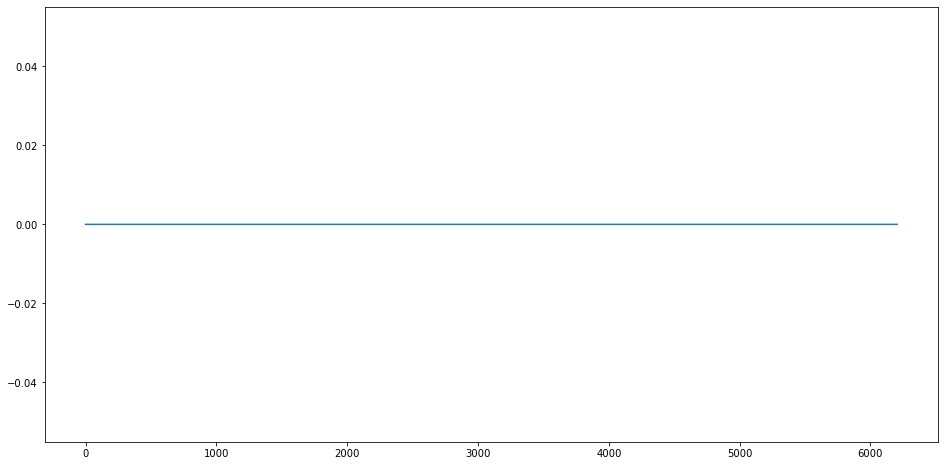

In [50]:
plt.figure(figsize=(16,8))

# for i in range(6):
plt.plot(G_approx[:,2])

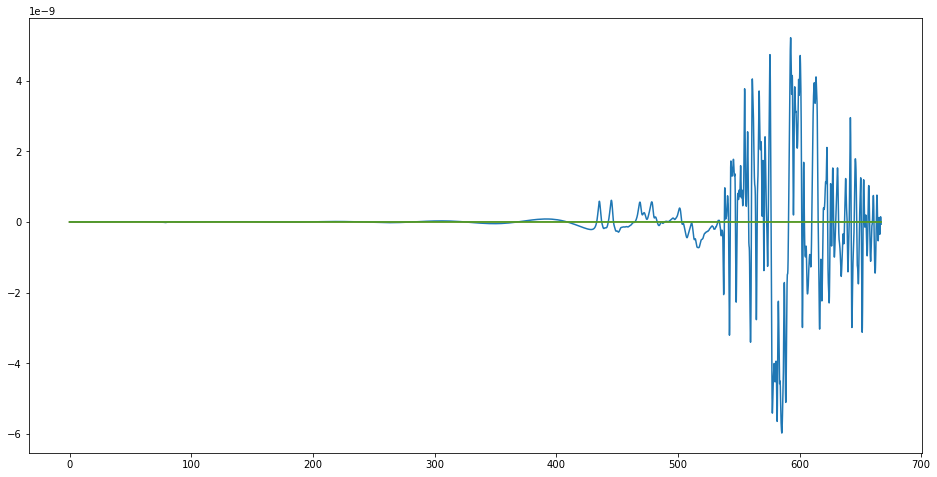

In [67]:
st_file = "/home/nienke/Documents/Research/SS_MTI/External_packages/Test_reflectivity/Exact_Gradient/Exact_5/"
st_syn = Gradient.read_refl_mseeds(path=st_file, stack=False)
plt.figure(figsize=(16,8))

for tr in st_syn:
    plt.plot(tr.times(),tr.data)

## 2. Invert the structure using approximate gradient